# UK Biobank (UKB) - Plot PC loadings

Create hexbin plots for first 40 UKB PC loadings.

In [ ]:
import pathlib
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
import json
import matplotlib.pyplot as plt
import seaborn as sns
import hail as hl

hl.init(spark_conf={'spark.driver.memory': '14g'})

In [ ]:
# Lifted from seaborn source code
def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    iqr = np.subtract.reduce(np.nanpercentile(a, [75, 25]))
    h = 2 * iqr / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))

### Generate hexbin plots for first 40 UKB PC loadings, save as PDF and PNG files:

In [ ]:
plt.ioff()

bucket = 'ukb-data'
version = 'genotypes'
samples = '337111-samples'
# samples = '406696-samples'
gcs_prefix = f'gs://{bucket}/{version}/{samples}/pca-sm-whitened-02'

k = 100
n_loadings = 40

for w in [0, 30, 100, 300]:
    print(f'Window size = {w}.')
    scores_fname = f'full-scores-ws{w}-k{k}'
    scores_ht = f'{gcs_prefix}/{scores_fname}.ht'
    
    loadings_fname = f'full-loadings-ws{w}-k{k}'
    loadings_ht = f'{gcs_prefix}/{loadings_fname}.ht'
    
    # Load scores table and get sample count
    scores = hl.read_table(scores_ht)
    n_samples = scores.count()

    # Load loadings table, ensure that they are ordered by locus prior to adding an index for plotting
    loadings = hl.read_table(loadings_ht)
    loadings = loadings.order_by(hl.asc('locus')).key_by('locus', 'alleles').add_index('locus_index')
    n_variants = loadings.count()

    # Pull out each PC loading to it's own field, convert table to pandas df for plotting
    loading_labels = hl.array([f'pc{i}_loading' for i in range(1, n_loadings + 1)])
    loadings = loadings.annotate(
        **{k: loadings.loadings[loading_labels.index(k)] for k in loading_labels.collect()[0]}
    )
    loadings_pd = loadings.to_pandas()

    # Set loading plot title and output directory
    if samples == '406696-samples':
        subset = 'Pan-UKB'
    elif samples == '337111-samples':
        subset = 'White British Subset'
    plot_title = (f'\nUK Biobank PC Loadings: {subset}\n' 
                  f'Computed on {n_samples} samples and {n_variants} SNPs, w = {w}.\n')
    output_dir = f'/Users/pcumming/pca/UKB/plots/{samples}'
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    sns.set_theme(style='ticks')
    nrows, ncols = int(n_loadings / 5), 5
    fig, axs = plt.subplots(nrows, ncols, 
                            figsize=(27.5, n_loadings), 
                            sharex=False, 
                            sharey=False, 
                            constrained_layout=True)    
    fig.suptitle(plot_title, fontsize=16, ha='center')
    cmap = sns.color_palette('viridis', as_cmap=True)

    # Use k_idx to iterate through PC loadings
    k_idx = 1
    for i in range(nrows):
        for j in range(ncols):
            # Create the (i,j)-th hexbin plot from pandas DataFrame
            x = loadings_pd['locus_index']
            y = loadings_pd[f'pc{k_idx}_loading']
            y_lim = max(abs(y.min()), abs(y.max()))

            x_bins = min(_freedman_diaconis_bins(x), 50)
            y_bins = min(_freedman_diaconis_bins(y), 50)
            gridsize = int(np.mean([x_bins, y_bins]))

            hb = axs[i, j].hexbin(x=x, y=y, gridsize=gridsize, cmap=cmap, mincnt=1)
            axs[i, j].ticklabel_format(axis='x', style='scientific', scilimits=(0,0), useMathText=True)
            axs[i, j].set_title(f'PC{k_idx}, excess kurtosis = {np.round(kurtosis(y, fisher=True), 2)}', loc='left')
            axs[i, j].set_xlabel('Locus index')
            axs[i, j].set_ylabel('Loading value')
            axs[i, j].set_ylim(-y_lim, y_lim)

            cb = fig.colorbar(hb, ax=axs[i, j], location='right', pad=0.01, fraction=0.1, aspect=30)
            cb.ax.set_title('Count', loc='left')

            k_idx += 1

    plt.savefig(f'{output_dir}/{loadings_fname}-plot.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/{loadings_fname}-plot.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

### Generate UKB excess kurtosis plots:

#### Create nested dictionary with excess kurtosis for each window size:

In [ ]:
bucket = 'gs://ukb-data'
version = 'genotypes'
samples = '337111-samples'
# samples = '406696-samples'
gcs_prefix = f'{bucket}/{version}/{samples}/pca-sm-whitened-02'

k = 100
n_loadings = 100

output_dir = f'/Users/pcumming/pca/UKB/plots/{samples}'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

excess_kurtosis = {}

for w in [0, 30, 100, 300]:
    print(f'Window size = {w}.')
    scores_fname = f'full-scores-ws{w}-k{k}'
    scores_ht = f'{gcs_prefix}/{scores_fname}.ht'

    loadings_fname = f'full-loadings-ws{w}-k{k}'
    loadings_ht = f'{gcs_prefix}/{loadings_fname}.ht'

    # Load scores table and get sample count
    scores = hl.read_table(scores_ht)
    n_samples = scores.count()

    # Load loadings table, ensure that they are ordered by locus prior to adding an index for plotting
    loadings = hl.read_table(loadings_ht)
    loadings = loadings.order_by(hl.asc('locus')).key_by('locus', 'alleles').add_index('locus_index')
    n_variants = loadings.count()

    # Pull out each PC loading to it's own field, convert table to pandas df for plotting
    loading_labels = hl.array([f'pc{i}_loading' for i in range(1, n_loadings + 1)])
    loadings = loadings.annotate(
        **{k: loadings.loadings[loading_labels.index(k)] for k in loading_labels.collect()[0]}
    )
    loadings_pd = loadings.to_pandas()

    # Create dict for each w, formatted like {ith_pc_loading: excess_kurtosis}
    excess_kurtosis_w = {}
    for i in range(1, n_loadings + 1):
        excess_kurtosis_w[i] = kurtosis(loadings_pd[f'pc{i}_loading'], fisher=True)

    # Insert dict created above into a nested dict, formatted like {w: {ith_pc_loading: excess_kurtosis}}
    excess_kurtosis[w] = excess_kurtosis_w

with open(f'{output_dir}/excess_kurtosis.json', 'w') as f:
    json.dump(excess_kurtosis, f)

#### Load nested dictionary with excess kurtosis for each window size into a pandas Dataframe:

In [5]:
samples = '337111-samples'
# samples = '406696-samples'
output_dir = f'/Users/pcumming/pca/UKB/plots/{samples}'
with open (f'{output_dir}/excess_kurtosis.json', 'r') as f:
    excess_kurtosis = json.load(f)

excess_kurtosis_pd = pd.DataFrame.from_dict(excess_kurtosis)
excess_kurtosis_pd

,0,30,100,300
1,0.174587,0.115778,0.105650,0.109770
2,0.311186,0.347929,0.316936,0.287933
3,0.086847,0.081842,0.076945,0.072165
4,0.113977,0.116326,0.097894,0.078514
5,0.160728,0.101191,0.109299,0.123641
...,...,...,...,...
96,4.750919,0.390657,0.665051,0.272433
97,5.447329,0.343880,0.301129,0.361747
98,5.086619,0.357877,0.305155,0.377363
99,5.907161,0.311595,0.293459,0.194860


### Create excess kurtosis plot:

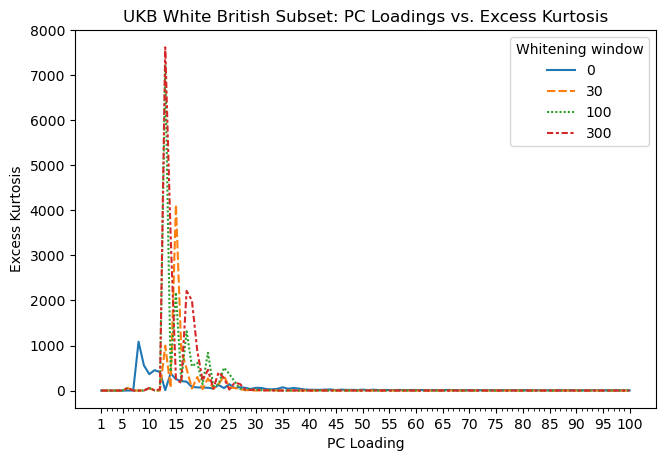

In [6]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)

output_dir = f'/Users/pcumming/pca/UKB/plots/{samples}'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(7.5, 5), dpi=100)
ax = sns.lineplot(data=excess_kurtosis_pd, lw=1.5)
if samples == '406696-samples':
    ax.set_title('Pan-UKB: PC Loadings vs. Excess Kurtosis')
elif samples == '337111-samples':
    ax.set_title('UKB White British Subset: PC Loadings vs. Excess Kurtosis')
ax.set_xlabel('PC Loading')
ax.set_ylabel('Excess Kurtosis')
ax.legend(title='Whitening window')
ax.xaxis.set_major_locator(FixedLocator([0] + list(range(4, 100, 5))))
ax.xaxis.set_minor_locator(FixedLocator(list(range(100))))

plt.savefig(f'{output_dir}/excess_kurtosis.png')

### Create censored excess kurtosis plot:

In [7]:
excess_kurtosis_censored_pd = excess_kurtosis_pd
excess_kurtosis_censored_pd[excess_kurtosis_censored_pd > 100] = 100
excess_kurtosis_censored_pd

,0,30,100,300
1,0.174587,0.115778,0.105650,0.109770
2,0.311186,0.347929,0.316936,0.287933
3,0.086847,0.081842,0.076945,0.072165
4,0.113977,0.116326,0.097894,0.078514
5,0.160728,0.101191,0.109299,0.123641
...,...,...,...,...
96,4.750919,0.390657,0.665051,0.272433
97,5.447329,0.343880,0.301129,0.361747
98,5.086619,0.357877,0.305155,0.377363
99,5.907161,0.311595,0.293459,0.194860


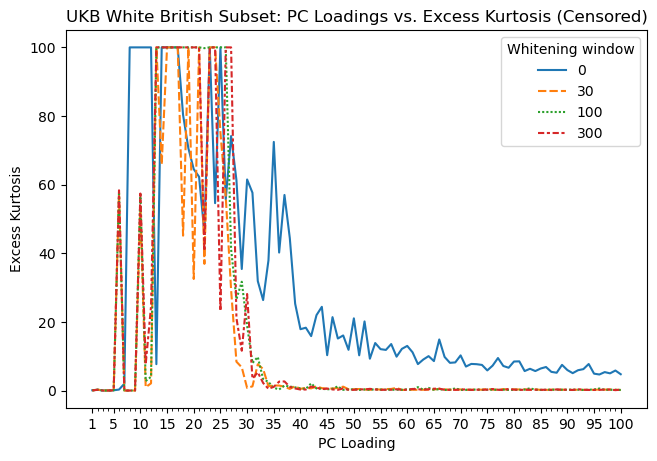

In [8]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)

output_dir = f'/Users/pcumming/pca/UKB/plots/{samples}'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(7.5, 5), dpi=100)
ax = sns.lineplot(data=excess_kurtosis_censored_pd, lw=1.5)
if samples == '406696-samples':
    ax.set_title('Pan-UKB: PC Loadings vs. Excess Kurtosis (Censored)')
elif samples == '337111-samples':
    ax.set_title('UKB White British Subset: PC Loadings vs. Excess Kurtosis (Censored)')
ax.set_xlabel('PC Loading')
ax.set_ylabel('Excess Kurtosis')
ax.legend(title='Whitening window')
ax.xaxis.set_major_locator(FixedLocator([0] + list(range(4, 100, 5))))
ax.xaxis.set_minor_locator(FixedLocator(list(range(100))))

plt.savefig(f'{output_dir}/excess_kurtosis_censored.png')